In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device('cuda')

In [3]:
# image loader
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        
        for filename in filenames:
            if contains is not None and filename.find(contains) == -1:
                continue
            
            ext = filename[filename.rfind("."):].lower()

            if ext.endswith(validExts):
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath

def load_images(directory='', size=(64,64)):
    images = []
    labels = [] 
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) 
            image = cv2.resize(image,size)

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [4]:
images=load_images('/home/temp_1/kangsanha/AnimeGan/For_pixel2style2pixel/AnimeGan/data')

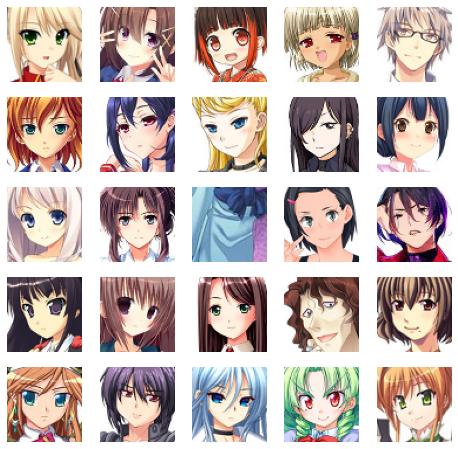

In [5]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [6]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.nz = params['nz']
        self.img_size = params['img_size']

        self.model = nn.Sequential(
            *self._fc_layer(self.nz, 128, normalize=False),
            *self._fc_layer(128,256),
            *self._fc_layer(256,512),
            *self._fc_layer(512,1024),
            nn.Linear(1024,int(np.prod(self.img_size))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_size)
        return img

    # fc layer
    def _fc_layer(self, in_channels, out_channels, normalize=True):
        layers = []
        layers.append(nn.Linear(in_channels, out_channels)) # fc layer
        if normalize:
            layers.append(nn.BatchNorm1d(out_channels, 0.8)) # BN
        layers.append(nn.LeakyReLU(0.2)) # LeakyReLU
        return layers

# check
params = {'nz':100,
          'img_size':(3,64,64)}
x = torch.randn(16,100).to(device) # random noise
model_gen = Generator(params).to(device)
output = model_gen(x) # noise를 입력받아 이미지 생성
print(output.shape)

torch.Size([16, 3, 64, 64])


In [7]:
class Discriminator(nn.Module):
    def __init__(self,params):
        super().__init__()
        self.img_size = params['img_size']

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = self.model(x)
        return x

# check
x = torch.randn(16,3,64,64).to(device)
model_dis = Discriminator(params).to(device)
output = model_dis(x)
print(output.shape)

torch.Size([16, 1])


In [8]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [9]:
# 손실 함수
loss_func = nn.BCELoss()

from torch import optim

# 최적화 파라미터
lr = 2e-4
beta1 = 0.5

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,0.999))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,0.999))

In [10]:
real_label = 1.
fake_label = 0.
nz = params['nz']
num_epochs = 100

loss_history={'gen':[],
              'dis':[]}